# Import 

In [1]:
from dask.distributed import LocalCluster

# https://forum.access-hive.org.au/t/netcdf-not-a-valid-id-errors/389/12
cluster = LocalCluster(threads_per_worker=1)          # Fully-featured local Dask cluster
client = cluster.get_client()
client

<Client: 'tcp://127.0.0.1:43767' processes=56 threads=56, memory=755.78 GiB>

In [2]:
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
import sys
from pathlib import Path
from string import ascii_lowercase, ascii_uppercase

import cartopy.crs as ccrs

import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from cmap import Colormap


import numpy as np
import pandas as pd
import xarray as xr
from IPython.display import HTML, Image, display
from scipy import stats

# Constants

In [3]:
xr.set_options(keep_attrs=True)
infile_path = Path("/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/")
plt.rcParams.update({"font.size": 25})

# Functions

In [86]:
def plot_var_row(diff, diff_pv, sel_var, cmap = 'RdBu_r',  start_letter = 'a', xlabel_bool = False, to_pdf = True, set_title=True):
    kwargs = dict(cbar_kwargs = dict(pad = .01))
    
    p = diff[:].plot(
        x="lat", col="time", yincrease=False, robust=True, size = 6,
        cmap = cmap,
        **kwargs
    )
    cb = p.cbar
    # https://stackoverflow.com/questions/19219963/align-ticklabels-in-matplotlib-colorbar
    for t in cb.ax.get_yticklabels():
        t.set_horizontalalignment('right')   
        t.set_x(4.5)
    
    p.data = diff_pv  # u_pv #ttest_1samp(diff,'time')
    kwargs = dict(
        # colors=("k"),
        add_colorbar=False,
        levels=[0, 0.05],
        colors="none",
        hatches=[".", None]
        # linewidths=np.linspace(1, 4, 4),
    )
    p.map_dataarray(xr.plot.contourf, "lat", "plev", **kwargs)
    
    
    u_pv = xr_multipletest(diff_pv)[1]
    p.data = u_pv  # ttest_1samp(diff,'time')
    kwargs = dict(
        colors=("k"),
        add_colorbar=False,
        levels=[0, 0.32],  # 1-sigma
        # linewidths=np.linspace(1, 4, 4),
    )
    p.map_dataarray(xr.plot.contour, "lat", "plev", **kwargs)
    
    
    p.data = u_pv  # xr_multipletest(diff_pv)[1]#o3_pv
    kwargs = dict(
        colors=("k"),
        add_colorbar=False,
        levels=[0, 0.05],
        # linewidths=np.linspace(1, 4, 4),
    )
    #p.map_dataarray(xr.plot.contour, "lat", "plev", **kwargs)
    
    
    #p.set_titles("{value}",maxchar=9)
    p.set_xlabels(" ")
    p.set_ylabels(" ")
    if xlabel_bool: 
        p.fig.supxlabel("latitude [deg]")
    elif xlabel_bool == 'white':
        p.fig.supxlabel("latitude [deg]", color = 'white')
    else:        
        p.fig.supxlabel("")
        
    p.fig.supylabel("pressure [hPa]", x = 0)
    
    plt.ylim(300, 0.1)
    plt.yscale("log")
    
    lat = da_w_tpp.lat.values
    letter_ls = [chr(i).upper() for i in range(ord(start_letter),ord(start_letter)+5)]
    for i, (ax, sel_dict, label) in enumerate(
        zip(p.axes.flat, p.name_dicts.flat, letter_ls)
    ):
        fmt = mpl.ticker.FormatStrFormatter("%g")
        ax.yaxis.set_major_formatter(fmt)
        ax.text(
            0.05,
            0.95,
            label,#ascii_uppercase[j],#f'{sel_var[:-2]} ({label})',
            transform=ax.transAxes,
            fontsize=28,
            fontweight="bold",
            va="top",
            bbox={"alpha": 0.7, "facecolor": "white"},
        )
        ax.set_xticks([-45, 0, 45])
        #ax.set_xlabels
        if set_title:
            ax.set_title(np.datetime_as_string(sel_dict['time'], unit='M'), fontsize=28)
        else:
            ax.set_title('', fontsize=28)
            
        #print(xlabel_bool)
        if not xlabel_bool: 
            ax.set_xticklabels([])#ax.get_xaxis().set_visible(False)
        
        ax.tick_params('both', length=10, width=2, which='major')
        
        ax.plot(lat, da_w_tpp.sel(**sel_dict), "k--", lw=3)
    
    outfile = f"{sel_var}_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf"
    print(outfile)
    if to_pdf:
        plt.savefig(outfile, bbox_inches="tight")


def deseasonalize_func(ds):
    time_var = "time"
    climatology = ds.groupby(time_var + ".month").mean(time_var)
    anomalies = ds.copy()
    for sel_var in list(ds.data_vars)[:]:
        if sel_var in ["O3_m", "H2O_m"]:
            anomalies[sel_var] = (
                (
                    ds[sel_var].groupby(time_var + ".month") - climatology[sel_var]
                ).groupby(time_var + ".month")
                / climatology[sel_var]
                * 100
            )
            anomalies[sel_var].attrs["units"] = "%"
        else:
            anomalies[sel_var] = (
                ds[sel_var].groupby(time_var + ".month") - climatology[sel_var]
            )
            anomalies[sel_var].attrs["units"] = ds[sel_var].attrs["units"]
    return anomalies


def anomalize_func(ds):
    time_var = "time"
    climatology = (
        ds.sel(time=slice("2022-01", "2022-12"))
        .groupby(time_var + ".month")
        .mean(time_var)
    )
    anomalies = ds.copy()
    for sel_var in list(ds.data_vars)[:]:
        if sel_var in ["O3_m", "H2O_m"]:
            anomalies[sel_var] = (
                (ds[sel_var] - climatology[sel_var]) / climatology[sel_var] * 100
            )
            anomalies[sel_var].attrs["units"] = "%"
        else:
            anomalies[sel_var] = ds[sel_var] - climatology[sel_var]
            anomalies[sel_var].attrs["units"] = ds[sel_var].attrs["units"]
    return anomalies

def process_slp(ds, deseasonalize=True):
    #ds = ds.drop_vars(["var152", "time_bnds", "lat_bnds"], errors="ignore")
    ds["time"] = pd.date_range("2021-01", freq="M", periods=ds.time.shape[0])

    ds = ds.assign(psl=lambda x: x.psl /100.)
    ds["psl"].attrs["units"] = "hPa"
    
    if deseasonalize:
        ds = anomalize_func(ds)  # deseasonalize_func(ds)

    return ds#.sel(plev=slice(upper_limit, lower_limit))

def process_2t(ds, deseasonalize=True):
    #ds = ds.drop_vars(["var152", "time_bnds", "lat_bnds"], errors="ignore")
    ds["time"] = pd.date_range("2021-01", freq="M", periods=ds.time.shape[0])
    ds = ds.rename({"var167": "2t"})
    ds['2t'].attrs['units'] = 'K'
    ds['2t'].attrs['long_name'] = '2-metre temperature'
    #ds = ds.assign(psl=lambda x: x.psl /100.)
    #ds["psl"].attrs["units"] = "hPa"
    
    if deseasonalize:
        ds = anomalize_func(ds)  # deseasonalize_func(ds)

    return ds#.sel(plev=slice(upper_limit, lower_limit))

def process(ds, deseasonalize=True, upper_limit=0.1, lower_limit=300):
    ds = ds.drop_vars(["var152", "time_bnds", "lat_bnds"], errors="ignore")
    ds["time"] = pd.date_range("2021-01", freq="M", periods=ds.time.shape[0])
    ds["plev"] = ds.plev.values / 100.0
    ds["plev"].attrs["units"] = "hPa"
    ds["plev"].attrs["long_name"] = "pressure"
    ds["plev"].attrs["standard_name"] = "pressure"

    if deseasonalize:
        ds = anomalize_func(ds)  # deseasonalize_func(ds)

    return ds.sel(plev=slice(upper_limit, lower_limit))


def process_tpp(ds, deseasonalize=True, upper_limit=1, lower_limit=300):
    ds = ds.drop_vars(["var152", "time_bnds", "lat_bnds"], errors="ignore")
    ds["time"] = pd.date_range("2021-01", freq="M", periods=ds.time.shape[0])
    ds = ds.rename({"var237": "tpp"})
    ds["tpp"] = ds["tpp"] / 100.0

    ds["tpp"].attrs["units"] = "hPa"
    ds["tpp"].attrs["long_name"] = "tropopause pressure"
    # ds["plev"].attrs["standard_name"] = "pressure"

    if deseasonalize:
        ds = anomalize_func(ds)  # deseasonalize_func(ds)

    return ds


def process_daily(ds, deseasonalize=False):
    ds = ds.drop_vars(["var152", "time_bnds", "lat_bnds"], errors="ignore")
    ds["time"] = pd.date_range("2021-01", freq="D", periods=ds.time.shape[0])
    ds["plev"] = ds.plev.values / 100.0
    ds["plev"].attrs["units"] = "hPa"
    ds["plev"].attrs["long_name"] = "pressure"
    ds["plev"].attrs["standard_name"] = "pressure"

    if deseasonalize:
        ds = anomalize_func(ds)  # deseasonalize_func(ds)

    return ds.sel(plev=slice(1, 100))


def process_daily_sd(ds, deseasonalize=False):
    ds = ds.drop_vars(["var152", "time_bnds", "lat_bnds"], errors="ignore")
    ds["time"] = pd.date_range("2022-01", freq="D", periods=ds.time.shape[0])
    ds["plev"] = ds.plev.values / 100.0
    ds["plev"].attrs["units"] = "hPa"
    ds["plev"].attrs["long_name"] = "pressure"
    ds["plev"].attrs["standard_name"] = "pressure"

    if deseasonalize:
        ds = anomalize_func(ds)  # deseasonalize_func(ds)

    return ds.sel(plev=slice(1, 100))


def map_month(m):
    if m == 2:
        m_str = "DJF"
    elif m == 5:
        m_str = "MAM"
    elif m == 8:
        m_str = "JJA"
    elif m == 11:
        m_str = "SON"
    else:
        m_str = "NaN"

    return m_str


def map_time_str(time):
    year_arr = time.dt.year.values
    month_arr = time.dt.month.values

    month_str_ls = list(map(map_month, month_arr))
    func = lambda x, y: str(x) + "-" + y
    date_str = list(map(func, year_arr, month_str_ls))

    return date_str


def integrate_wv(da):
    g = 9.81
    e = 0.622
    w = area_weights  # .mean(axis = 1)
    # from kg to g and then to Tg
    integral = (da * w * plev_diff * e / g).sum(["lat", "plev", "lon"]) * 1000 / 1e12

    return integral


EARTH_RADIUS = 6371000.0  # m


def _guess_bounds(points, bound_position=0.5):
    """
    Guess bounds of grid cells.

    Simplified function from iris.coord.Coord.

    Parameters
    ----------
    points: numpy.array
        Array of grid points of shape (N,).
    bound_position: float, optional
        Bounds offset relative to the grid cell centre.
    Returns
    -------
    Array of shape (N, 2).
    """
    diffs = np.diff(points)
    diffs = np.insert(diffs, 0, diffs[0])
    diffs = np.append(diffs, diffs[-1])

    min_bounds = points - diffs[:-1] * bound_position
    max_bounds = points + diffs[1:] * (1 - bound_position)

    return np.array([min_bounds, max_bounds]).transpose()


def _quadrant_area(radian_lat_bounds, radian_lon_bounds, radius_of_earth):
    """
    Calculate spherical segment areas.
    Taken from SciTools iris library.
    Area weights are calculated for each lat/lon cell as:
        .. math::
            r^2 (lon_1 - lon_0) ( sin(lat_1) - sin(lat_0))
    The resulting array will have a shape of
    *(radian_lat_bounds.shape[0], radian_lon_bounds.shape[0])*
    The calculations are done at 64 bit precision and the returned array
    will be of type numpy.float64.
    Parameters
    ----------
    radian_lat_bounds: numpy.array
        Array of latitude bounds (radians) of shape (M, 2)
    radian_lon_bounds: numpy.array
        Array of longitude bounds (radians) of shape (N, 2)
    radius_of_earth: float
        Radius of the Earth (currently assumed spherical)
    Returns
    -------
    Array of grid cell areas of shape (M, N).
    """
    # ensure pairs of bounds
    if (
        radian_lat_bounds.shape[-1] != 2
        or radian_lon_bounds.shape[-1] != 2
        or radian_lat_bounds.ndim != 2
        or radian_lon_bounds.ndim != 2
    ):
        raise ValueError("Bounds must be [n,2] array")

    # fill in a new array of areas
    radius_sqr = radius_of_earth**2
    radian_lat_64 = radian_lat_bounds.astype(np.float64)
    radian_lon_64 = radian_lon_bounds.astype(np.float64)

    ylen = np.sin(radian_lat_64[:, 1]) - np.sin(radian_lat_64[:, 0])
    xlen = radian_lon_64[:, 1] - radian_lon_64[:, 0]
    areas = radius_sqr * np.outer(ylen, xlen)

    # we use abs because backwards bounds (min > max) give negative areas.
    return np.abs(areas)


def grid_cell_areas(lon1d, lat1d, radius=EARTH_RADIUS):
    """
    Calculate grid cell areas given 1D arrays of longitudes and latitudes
    for a planet with the given radius.

    Parameters
    ----------
    lon1d: numpy.array
        Array of longitude points [degrees] of shape (M,)
    lat1d: numpy.array
        Array of latitude points [degrees] of shape (M,)
    radius: float, optional
        Radius of the planet [metres] (currently assumed spherical)
    Returns
    -------
    Array of grid cell areas [metres**2] of shape (M, N).
    """
    lon_bounds_radian = np.deg2rad(_guess_bounds(lon1d))
    lat_bounds_radian = np.deg2rad(_guess_bounds(lat1d))
    area = _quadrant_area(lat_bounds_radian, lon_bounds_radian, radius)
    return area


def show_gif(fname):
    import base64

    from IPython import display

    with open(fname, "rb") as fd:
        b64 = base64.b64encode(fd.read()).decode("ascii")
    return display.HTML(f'<img src="data:image/gif;base64,{b64}" />')


def ttest_1samp(a, dim):
    """
    This is a two-sided test for the null hypothesis that the expected value
    (mean) of a sample of independent observations `a` is equal to the given
    population mean, `popmean`

    Inspired here: https://github.com/scipy/scipy/blob/v0.19.0/scipy/stats/stats.py#L3769-L3846

    Parameters
    ----------
    a : xarray
        sample observation
    popmean : float or array_like
        expected value in null hypothesis, if array_like than it must have the
        same shape as `a` excluding the axis dimension
    dim : string
        dimension along which to compute test

    Returns
    -------
    mean : xarray
        averaged sample along which dimension t-test was computed
    pvalue : xarray
        two-tailed p-value
    """
    n = a[dim].shape[0]
    df = n - 1
    # a_mean = a.mean(dim)
    # d = a_mean - popmean
    v = a.var(dim, ddof=1)
    denom = np.sqrt(v / float(n))

    t = a / denom
    prob = stats.distributions.t.sf(np.fabs(t), df) * 2
    prob_xa = xr.DataArray(prob, coords=a.coords)
    return prob_xa.squeeze()


# https://wiki.mpimet.mpg.de/doku.php?id=analysis:pot_pourri:statistics:controlling_fdr
def xr_multipletest(p, alpha=0.05, method="fdr_bh", **multipletests_kwargs):
    """Apply statsmodels.stats.multitest.multipletests for multi-dimensional xr.objects."""
    from statsmodels.stats.multitest import multipletests

    # stack all to 1d array
    p_stacked = p.stack(s=p.dims)
    # mask only where not nan: https://github.com/statsmodels/statsmodels/issues/2899
    mask = np.isfinite(p_stacked)
    pvals_corrected = np.full(p_stacked.shape, np.nan)
    reject = np.full(p_stacked.shape, np.nan)
    # apply test where mask
    reject[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs
    )[0]
    pvals_corrected[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs
    )[1]

    def unstack(reject, p_stacked):
        """Exchange values from p_stacked with reject (1d array) and unstack."""
        xreject = p_stacked.copy()
        xreject.values = reject
        xreject = xreject.unstack()
        return xreject

    reject = unstack(reject, p_stacked)
    pvals_corrected = unstack(pvals_corrected, p_stacked)
    return reject, pvals_corrected

# Load dataset

## water vapour

In [5]:
what = "H2O_m"
infiles_w = list(infile_path.glob(f"socol4_htt1*{what}*"))
infiles_wo = list(infile_path.glob(f"socol4_htt2*{what}*"))

In [6]:
infiles_wo

[PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt23_H2O_m_2021-2025_daily.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt22_H2O_m_2021-2025_daily.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt20_H2O_m_2021-2025_daily.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt21_H2O_m_2021-2025_daily.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt24_H2O_m_2021-2025_daily.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt25_H2O_m_2021-2025_daily.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt27_H2O_m_2021-2025_daily.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt26_H2O_m_2021-2025_daily.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt28_H2O_m_2021-2025_daily.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt29_H2O_m_2021-2025_daily.nc')]

In [7]:
ds_w_wv = xr.open_mfdataset(
    infiles_w,
    parallel=True,  #  will be performed in parallel using dask.delayed
    combine="nested",
    concat_dim=["ens"],
    # chunks = dict(plev = 1, time = 365)
).pipe(
    process_daily, deseasonalize=False
)  # .chunk(plev = 1, time = 365)
# ds_w_wv["ens"] = ens_name_ls
ds_w_wv

<xarray.Dataset> Size: 23GB
Dimensions:  (time: 1826, lon: 192, lat: 96, plev: 17, ens: 10)
Coordinates:
  * time     (time) datetime64[ns] 15kB 2021-01-01 2021-01-02 ... 2025-12-31
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat      (lat) float64 768B 88.57 86.72 84.86 83.0 ... -84.86 -86.72 -88.57
  * plev     (plev) float64 136B 1.0 1.215 1.929 2.957 ... 74.06 91.02 100.0
Dimensions without coordinates: ens
Data variables:
    H2O_m    (ens, time, plev, lat, lon) float32 23GB dask.array<chunksize=(1, 1826, 17, 96, 192), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Mon Feb 26 14:43:50 2024: cdo cat rr3.nc /scratch/snx3000/a...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [8]:
ds_wo_wv = xr.open_mfdataset(
    infiles_wo,
    parallel=True,  #  will be performed in parallel using dask.delayed
    combine="nested",
    concat_dim=["ens"],
    # chunks = dict(plev = 1, time = 365)
).pipe(process_daily, deseasonalize=False)
ds_wo_wv

/hpx/Data_impb/kales/conda/envs/myenv/lib/python3.11/site-packages/xarray/core/indexing.py:1593: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/hpx/Data_impb/kales/conda/envs/myenv/lib/python3.11/site-packages/xarray/core/indexing.py:1593: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.arr

<xarray.Dataset> Size: 23GB
Dimensions:  (time: 1826, lon: 192, lat: 96, plev: 17, ens: 10)
Coordinates:
  * time     (time) datetime64[ns] 15kB 2021-01-01 2021-01-02 ... 2025-12-31
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat      (lat) float64 768B 88.57 86.72 84.86 83.0 ... -84.86 -86.72 -88.57
  * plev     (plev) float64 136B 1.0 1.215 1.929 2.957 ... 74.06 91.02 100.0
Dimensions without coordinates: ens
Data variables:
    H2O_m    (ens, time, plev, lat, lon) float32 23GB dask.array<chunksize=(1, 1826, 17, 96, 192), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Mon Feb 26 16:11:55 2024: cdo cat rr3.nc /scratch/snx3000/a...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

## tropopause

In [9]:
what = "tropopause"
infiles_w = sorted(infile_path.glob(f"socol4_htt1?_{what}_*"))
infiles_wo = sorted(infile_path.glob(f"socol4_htt2?_{what}_*"))

In [11]:
ds_w_tpp = (
    xr.open_mfdataset(
        infiles_w,
        parallel=True,  #  will be performed in parallel using dask.delayed
        combine="nested",
        concat_dim=["ens"],
    )
    .pipe(process_tpp, deseasonalize=False)
    .load()
)
ds_w_tpp

/tmp/ipykernel_33153/748009670.py:178: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ds["time"] = pd.date_range("2021-01", freq="M", periods=ds.time.shape[0])


<xarray.Dataset> Size: 44MB
Dimensions:  (time: 60, lon: 192, lat: 96, ens: 10)
Coordinates:
  * time     (time) datetime64[ns] 480B 2021-01-31 2021-02-28 ... 2025-12-31
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat      (lat) float64 768B 88.57 86.72 84.86 83.0 ... -84.86 -86.72 -88.57
Dimensions without coordinates: ens
Data variables:
    tpp      (ens, time, lat, lon) float32 44MB 254.9 254.9 ... 201.6 201.6
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    institution:  Max Planck Institute for Meteorology
    history:      Thu Mar 21 18:04:20 2024: cdo cat ttsocol4_htt1011.nc /scra...
    frequency:    mon
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [12]:
ds_wo_tpp = (
    xr.open_mfdataset(
        infiles_wo,
        parallel=True,  #  will be performed in parallel using dask.delayed
        combine="nested",
        concat_dim=["ens"],
    )
    .pipe(process_tpp, deseasonalize=False)
    .load()
)
ds_wo_tpp

/tmp/ipykernel_33153/748009670.py:178: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ds["time"] = pd.date_range("2021-01", freq="M", periods=ds.time.shape[0])


<xarray.Dataset> Size: 44MB
Dimensions:  (time: 60, lon: 192, lat: 96, ens: 10)
Coordinates:
  * time     (time) datetime64[ns] 480B 2021-01-31 2021-02-28 ... 2025-12-31
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat      (lat) float64 768B 88.57 86.72 84.86 83.0 ... -84.86 -86.72 -88.57
Dimensions without coordinates: ens
Data variables:
    tpp      (ens, time, lat, lon) float32 44MB nan nan nan ... 246.3 246.3
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    institution:  Max Planck Institute for Meteorology
    history:      Thu Mar 21 18:04:40 2024: cdo cat ttsocol4_htt2011.nc /scra...
    frequency:    mon
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

## HOx

In [14]:
what = "OHx_mm_zon"
infiles_w = list(infile_path.glob(f"socol4_htt1*{what}*"))
infiles_wo = list(infile_path.glob(f"socol4_htt2*{what}*"))

In [15]:
ds_w_hox = (
    xr.open_mfdataset(
        infiles_w,
        parallel=True,  #  will be performed in parallel using dask.delayed
        combine="nested",
        concat_dim=["ens"],
    )
    .pipe(process, deseasonalize=False, upper_limit=0.1)
    .load()
)
ds_w_hox

/tmp/ipykernel_33153/748009670.py:164: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ds["time"] = pd.date_range("2021-01", freq="M", periods=ds.time.shape[0])


<xarray.Dataset> Size: 6MB
Dimensions:  (time: 60, lon: 1, lat: 96, plev: 26, ens: 10)
Coordinates:
  * time     (time) datetime64[ns] 480B 2021-01-31 2021-02-28 ... 2025-12-31
  * lon      (lon) float64 8B 0.0
  * lat      (lat) float64 768B 88.57 86.72 84.86 83.0 ... -84.86 -86.72 -88.57
  * plev     (plev) float64 208B 0.1112 0.2315 0.4259 ... 208.7 238.3 270.1
Dimensions without coordinates: ens
Data variables:
    OH_m     (ens, time, plev, lat, lon) float32 6MB 2.323e-12 ... 2.807e-13
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Fri Mar 22 14:28:51 2024: cdo cat Postproc_example-OHx-para...
    frequency:    mon
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [16]:
ds_wo_hox = (
    xr.open_mfdataset(
        infiles_wo,
        parallel=True,  #  will be performed in parallel using dask.delayed
        combine="nested",
        concat_dim=["ens"],
    )
    .pipe(process, deseasonalize=False, upper_limit=0.1)
    .load()
)
ds_wo_hox

/tmp/ipykernel_33153/748009670.py:164: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ds["time"] = pd.date_range("2021-01", freq="M", periods=ds.time.shape[0])


<xarray.Dataset> Size: 6MB
Dimensions:  (time: 60, lon: 1, lat: 96, plev: 26, ens: 10)
Coordinates:
  * time     (time) datetime64[ns] 480B 2021-01-31 2021-02-28 ... 2025-12-31
  * lon      (lon) float64 8B 0.0
  * lat      (lat) float64 768B 88.57 86.72 84.86 83.0 ... -84.86 -86.72 -88.57
  * plev     (plev) float64 208B 0.1112 0.2315 0.4259 ... 208.7 238.3 270.1
Dimensions without coordinates: ens
Data variables:
    OH_m     (ens, time, plev, lat, lon) float32 6MB nan nan ... 3.056e-13
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Fri Mar 22 14:29:26 2024: cdo cat Postproc_example-OHx-para...
    frequency:    mon
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

## SLP

In [ ]:
what = "slp_mm"
infiles_w = list(infile_path.glob(f"socol4_htt1*{what}*"))
infiles_wo = list(infile_path.glob(f"socol4_htt2*{what}*"))

In [ ]:
ds_w_slp = (
    xr.open_mfdataset(
        infiles_w,
        parallel=True,  #  will be performed in parallel using dask.delayed
        combine="nested",
        concat_dim=["ens"],
    )
    .pipe(process_slp, deseasonalize=False)
    .load()
)
ds_w_slp

In [103]:
ds_wo_slp = (
    xr.open_mfdataset(
        infiles_wo,
        parallel=True,  #  will be performed in parallel using dask.delayed
        combine="nested",
        concat_dim=["ens"],
    )
    .pipe(process_slp, deseasonalize=False)
    .load()
)
ds_wo_slp

/tmp/ipykernel_41396/3936270894.py:44: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ds["time"] = pd.date_range("2021-01", freq="M", periods=ds.time.shape[0])


<xarray.Dataset> Size: 44MB
Dimensions:    (time: 60, lon: 192, lat: 96, ens: 10, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 480B 2021-01-31 2021-02-28 ... 2025-12-31
  * lon        (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
  * lat        (lat) float64 768B 88.57 86.72 84.86 ... -84.86 -86.72 -88.57
Dimensions without coordinates: ens, bnds
Data variables:
    time_bnds  (ens, time, bnds) float64 10kB nan nan ... 2.025e+07 2.025e+07
    psl        (ens, time, lat, lon) float32 44MB nan nan nan ... 997.6 997.6
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    frequency:    mon
    history:      Thu May 09 21:43:47 2024: cdo cat Postproc_example-slp-para...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

## 2m temperature

In [104]:
what = "2t_mm"
infiles_w = list(infile_path.glob(f"socol4_htt1*{what}*"))
infiles_wo = list(infile_path.glob(f"socol4_htt2*{what}*"))

In [105]:
ds_w_2t = (
    xr.open_mfdataset(
        infiles_w,
        parallel=True,  #  will be performed in parallel using dask.delayed
        combine="nested",
        concat_dim=["ens"],
    )
    .pipe(process_2t, deseasonalize=False)
    .load()
)
ds_w_2t

/tmp/ipykernel_41396/3936270894.py:56: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ds["time"] = pd.date_range("2021-01", freq="M", periods=ds.time.shape[0])


<xarray.Dataset> Size: 44MB
Dimensions:    (time: 60, ens: 10, bnds: 2, lon: 192, lat: 96)
Coordinates:
  * time       (time) datetime64[ns] 480B 2021-01-31 2021-02-28 ... 2025-12-31
  * lon        (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
  * lat        (lat) float64 768B 88.57 86.72 84.86 ... -84.86 -86.72 -88.57
Dimensions without coordinates: ens, bnds
Data variables:
    time_bnds  (ens, time, bnds) float64 10kB 2.021e+07 2.021e+07 ... 2.025e+07
    2t         (ens, time, lat, lon) float32 44MB 249.6 249.6 ... 242.2 242.2
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    institution:  Max Planck Institute for Meteorology
    frequency:    mon
    history:      Fri May 10 17:43:16 2024: cdo cat Postproc_example-2t-paral...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [106]:
ds_wo_2t = (
    xr.open_mfdataset(
        infiles_wo,
        parallel=True,  #  will be performed in parallel using dask.delayed
        combine="nested",
        concat_dim=["ens"],
    )
    .pipe(process_2t, deseasonalize=False)
    .load()
)
ds_wo_2t

/tmp/ipykernel_41396/3936270894.py:56: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ds["time"] = pd.date_range("2021-01", freq="M", periods=ds.time.shape[0])


<xarray.Dataset> Size: 44MB
Dimensions:    (time: 60, lon: 192, lat: 96, ens: 10, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 480B 2021-01-31 2021-02-28 ... 2025-12-31
  * lon        (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
  * lat        (lat) float64 768B 88.57 86.72 84.86 ... -84.86 -86.72 -88.57
Dimensions without coordinates: ens, bnds
Data variables:
    time_bnds  (ens, time, bnds) float64 10kB nan nan ... 2.025e+07 2.025e+07
    2t         (ens, time, lat, lon) float32 44MB nan nan nan ... 243.3 243.3
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    institution:  Max Planck Institute for Meteorology
    frequency:    mon
    history:      Fri May 10 17:43:24 2024: cdo cat Postproc_example-2t-paral...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

## Chemistry + dynamics

In [17]:
what = "chem_mm_zon"
infiles_w = list(infile_path.glob(f"socol4_htt1?_{what}*"))
infiles_wo = list(infile_path.glob(f"socol4_htt2?_{what}*"))

In [18]:
infiles_wo

[PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt28_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt29_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt24_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt25_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt27_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt26_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt23_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt22_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt20_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt21_chem_mm_zon_2021-2025.nc')]

In [19]:
ds_wo_chem = (
    xr.open_mfdataset(
        infiles_wo,
        parallel=True,  #  will be performed in parallel using dask.delayed
        combine="nested",
        concat_dim=["ens"],
    )
    .pipe(process, deseasonalize=False, upper_limit=0.01)
    .load()
)
ds_wo_chem

/tmp/ipykernel_33153/748009670.py:164: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ds["time"] = pd.date_range("2021-01", freq="M", periods=ds.time.shape[0])


<xarray.Dataset> Size: 25MB
Dimensions:  (time: 60, lon: 1, lat: 96, plev: 27, ens: 10)
Coordinates:
  * time     (time) datetime64[ns] 480B 2021-01-31 2021-02-28 ... 2025-12-31
  * lon      (lon) float64 8B 0.0
  * lat      (lat) float64 768B 88.57 86.72 84.86 83.0 ... -84.86 -86.72 -88.57
  * plev     (plev) float64 216B 0.04281 0.1112 0.2315 ... 208.7 238.3 270.1
Dimensions without coordinates: ens
Data variables:
    te_m     (ens, time, plev, lat, lon) float32 6MB nan nan nan ... 208.1 208.0
    u_m      (ens, time, plev, lat, lon) float32 6MB nan nan nan ... 5.389 3.692
    O3_m     (ens, time, plev, lat, lon) float32 6MB nan nan ... 7.298e-08
    H2O_m    (ens, time, plev, lat, lon) float32 6MB nan nan ... 1.806e-05
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Thu Feb 29 16:07:22 2024: cdo cat ss4.nc /scratch/snx3000/a...
    frequency:    mon
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [20]:
ds_w_chem = (
    xr.open_mfdataset(
        infiles_w,
        parallel=True,  #  will be performed in parallel using dask.delayed
        combine="nested",
        concat_dim=["ens"],
    )
    .pipe(process, deseasonalize=False, upper_limit=0.01)
    .load()
)
ds_w_chem

/tmp/ipykernel_33153/748009670.py:164: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ds["time"] = pd.date_range("2021-01", freq="M", periods=ds.time.shape[0])


<xarray.Dataset> Size: 25MB
Dimensions:  (time: 60, lon: 1, lat: 96, plev: 27, ens: 10)
Coordinates:
  * time     (time) datetime64[ns] 480B 2021-01-31 2021-02-28 ... 2025-12-31
  * lon      (lon) float64 8B 0.0
  * lat      (lat) float64 768B 88.57 86.72 84.86 83.0 ... -84.86 -86.72 -88.57
  * plev     (plev) float64 216B 0.04281 0.1112 0.2315 ... 208.7 238.3 270.1
Dimensions without coordinates: ens
Data variables:
    te_m     (ens, time, plev, lat, lon) float32 6MB 236.8 236.3 ... 212.2 212.3
    u_m      (ens, time, plev, lat, lon) float32 6MB -1.594 -1.359 ... -1.554
    O3_m     (ens, time, plev, lat, lon) float32 6MB 1.577e-06 ... 8.991e-08
    H2O_m    (ens, time, plev, lat, lon) float32 6MB 2.381e-06 ... 3.163e-05
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Tue Mar 12 10:25:13 2024: cdo cat ss4.nc /scratch/snx3000/a...
    frequency:    mon
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

# Visualization

## Temperature

In [87]:
time_slice = slice("2022-12-01", "2023-04-30")
sel_dict = dict(time=time_slice, lat=slice(None, None))
sel_var = "te_m"


arr1 = ds_w_chem[sel_var].sel(**sel_dict).squeeze().load()
arr2 = ds_wo_chem[sel_var].sel(**sel_dict).squeeze().load()
diff = ((arr1 - arr2)).mean("ens")
#diff["time"] = map_time_str(diff.time)
#diff.attrs["units"] = "%"

t_stat, p_values = stats.ttest_ind(
    arr1, arr2, equal_var=False
)  # , nan_policy = nan_policy)
diff_pv = xr.DataArray(p_values, coords=diff.coords)

/tmp/ipykernel_33153/1259965813.py:64: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  zip(p.axes.flat, p.name_dicts.flat, letter_ls)


te_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf


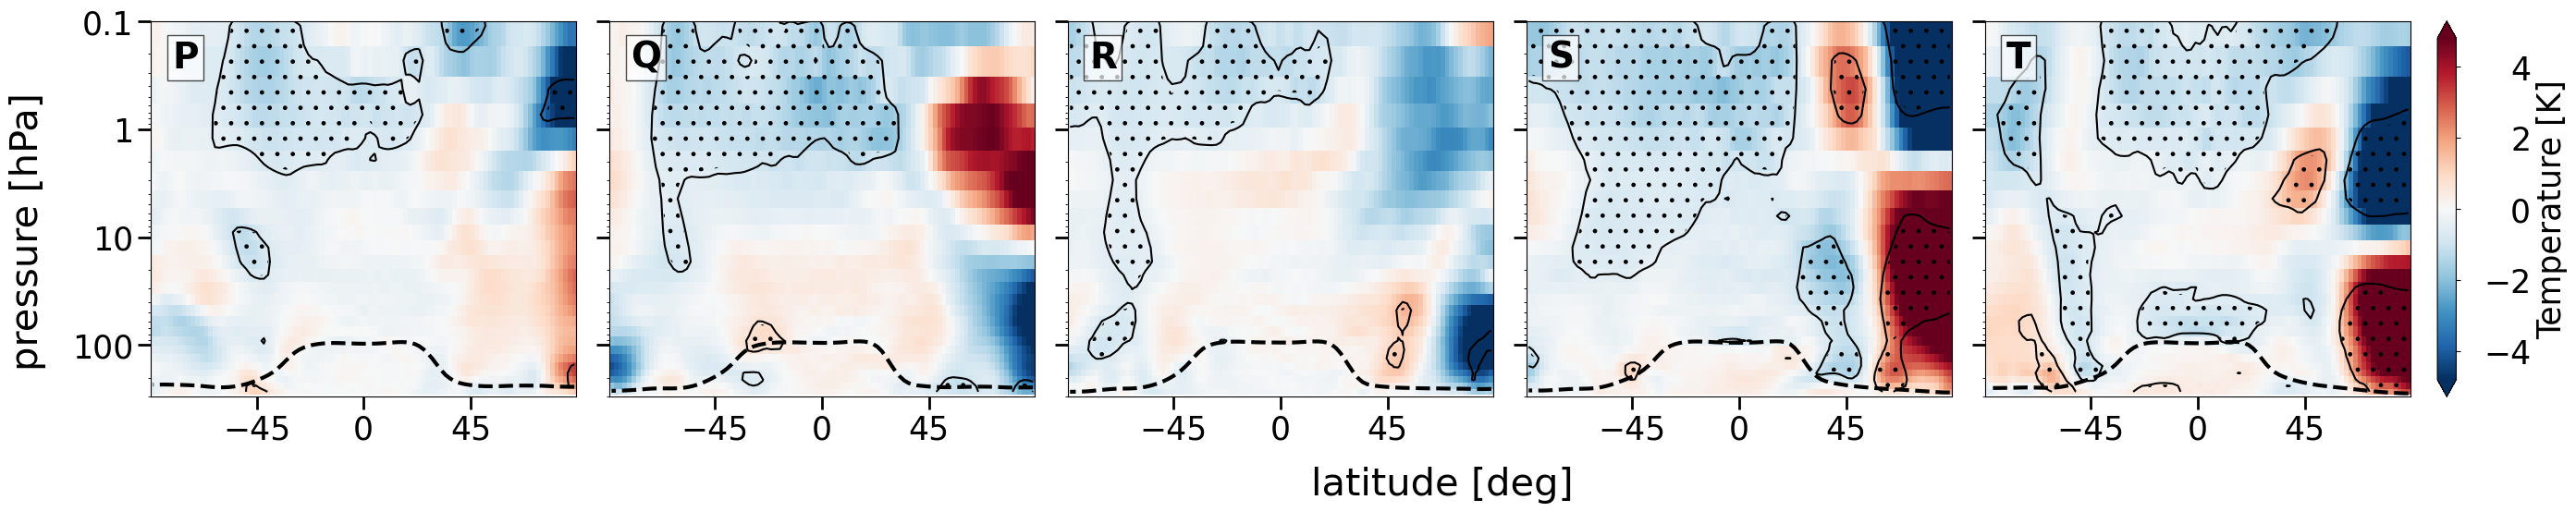

In [67]:
plot_var_row(diff, diff_pv, sel_var, cmap = 'RdBu_r', start_letter = 'p', xlabel_bool=True, to_pdf=True, set_title=False)

In [68]:
!pdfinfo te_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf


Creator:        Matplotlib v3.9.2, https://matplotlib.org
Producer:       Matplotlib pdf backend v3.9.2
CreationDate:   Mon Nov 18 15:27:29 2024 CET
Tagged:         no
UserProperties: no
Suspects:       no
Form:           none
JavaScript:     no
Pages:          1
Encrypted:      no
Page size:      2006.23 x 399.14 pts
Page rot:       0
File size:      315403 bytes
Optimized:      no
PDF version:    1.4


/tmp/ipykernel_41396/675725114.py:53: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  zip(p.axes.flat, p.name_dicts.flat, ascii_uppercase)


te_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf


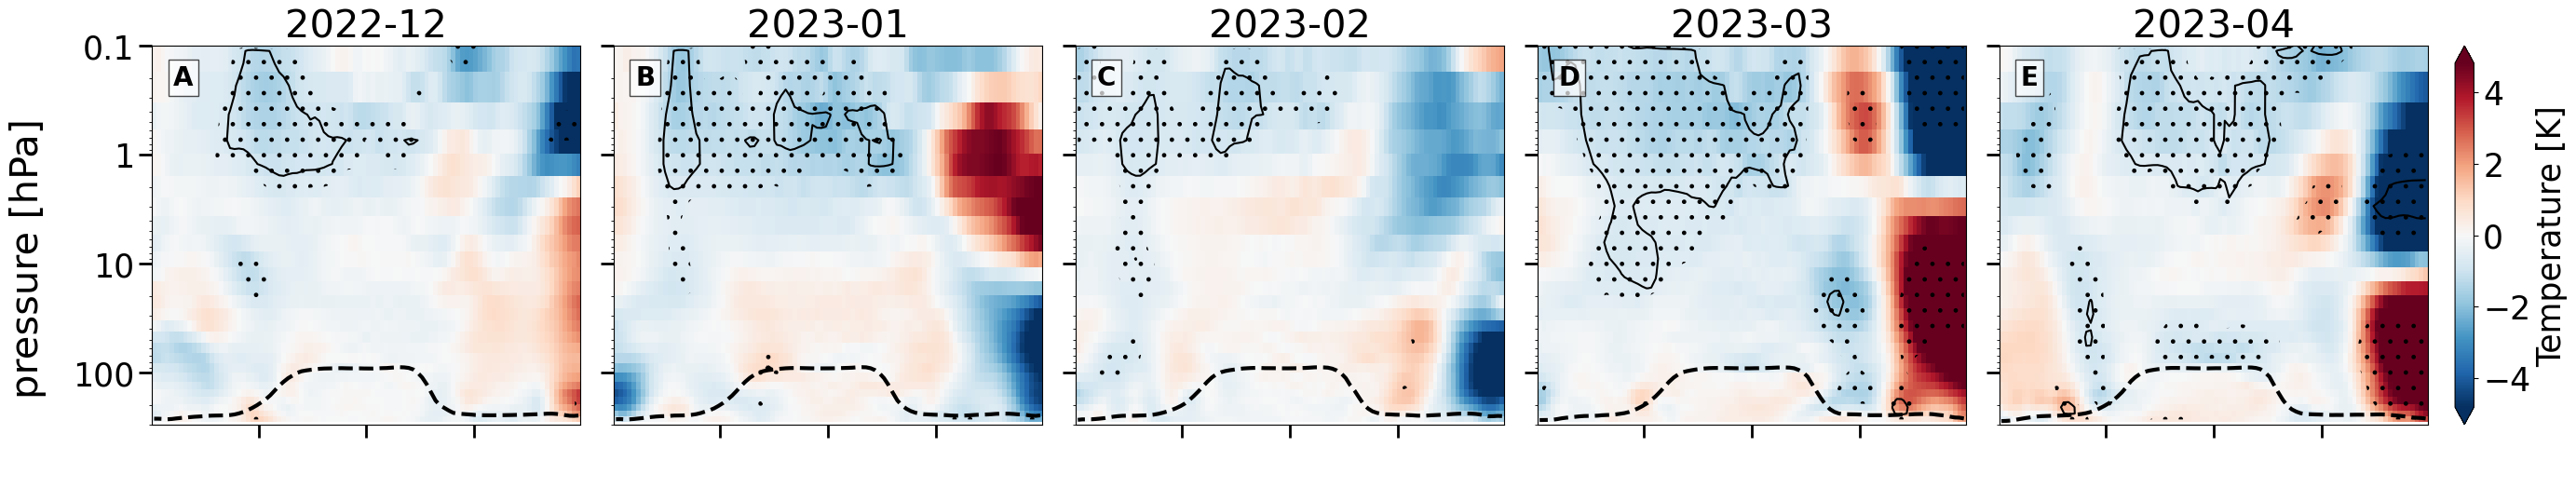

In [134]:
kwargs = dict(cbar_kwargs = dict(pad = 0.01))
p = diff[:].plot(
    x="lat", col="time", yincrease=False, robust=True, size = 6,
    **kwargs
)


p.data = diff_pv  # u_pv #ttest_1samp(diff,'time')
kwargs = dict(
    # colors=("k"),
    add_colorbar=False,
    levels=[0, 0.05],
    colors="none",
    hatches=[".", None]
    # linewidths=np.linspace(1, 4, 4),
)
p.map_dataarray(xr.plot.contourf, "lat", "plev", **kwargs)


u_pv = xr_multipletest(diff_pv)[1]
p.data = u_pv  # ttest_1samp(diff,'time')
kwargs = dict(
    colors=("k"),
    add_colorbar=False,
    levels=[0, 0.32],  # 1-sigma
    # linewidths=np.linspace(1, 4, 4),
)
p.map_dataarray(xr.plot.contour, "lat", "plev", **kwargs)


p.data = u_pv  # xr_multipletest(diff_pv)[1]#o3_pv
kwargs = dict(
    colors=("k"),
    add_colorbar=False,
    levels=[0, 0.05],
    # linewidths=np.linspace(1, 4, 4),
)
p.map_dataarray(xr.plot.contour, "lat", "plev", **kwargs)


#p.set_titles("{value}",maxchar=9)
p.set_xlabels(" ")
p.set_ylabels(" ")
#p.fig.supxlabel("latitude [deg]")
p.fig.supylabel("pressure [hPa]", x = 0)

plt.ylim(300, 0.1)
plt.yscale("log")

lat = da_w_tpp.lat.values
j = 0
for i, (ax, sel_dict, label) in enumerate(
    zip(p.axes.flat, p.name_dicts.flat, ascii_uppercase)
):
    fmt = mpl.ticker.FormatStrFormatter("%g")
    ax.yaxis.set_major_formatter(fmt)
    ax.text(
        0.05,
        0.95,
        ascii_uppercase[j],#f'{sel_var[:-2]} ({label})',
        transform=ax.transAxes,
        fontsize=20,
        fontweight="bold",
        va="top",
        bbox={"alpha": 0.7, "facecolor": "white"},
    )
    ax.set_xticks([-45, 0, 45])
    #ax.set_xlabels
    ax.set_title(np.datetime_as_string(sel_dict['time'], unit='M'))
    ax.set_xticklabels([])#ax.get_xaxis().set_visible(False)
    ax.tick_params('both', length=10, width=2, which='major')
    ax.plot(lat, da_w_tpp.sel(**sel_dict), "k--", lw=3)
    j+=1

outfile = f"{sel_var}_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf"
print(outfile)
plt.savefig(outfile, bbox_inches="tight")

## O3

In [88]:
time_slice = slice("2022-12-01", "2023-04-30")
sel_dict = dict(time=time_slice, lat=slice(None, None))
sel_var = "O3_m"


arr1 = ds_w_chem[sel_var].sel(**sel_dict).squeeze().load()
arr2 = ds_wo_chem[sel_var].sel(**sel_dict).squeeze().load()
diff = ((arr1 - arr2)/ arr1 * 100).mean("ens")
#diff["time"] = map_time_str(diff.time)
diff.attrs["units"] = "%"
diff.attrs["long_name"] = "O3 VMR"


t_stat, p_values = stats.ttest_ind(
    arr1, arr2, equal_var=False
)  # , nan_policy = nan_policy)
diff_pv = xr.DataArray(p_values, coords=diff.coords)

In [51]:
da_w_tpp = (
    ds_w_tpp["tpp"]
    .sel(**sel_dict)
    .mean(["lon", "ens"])
    .squeeze()
)

/tmp/ipykernel_33153/3005695306.py:66: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  zip(p.axes.flat, p.name_dicts.flat, letter_ls)


O3_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf


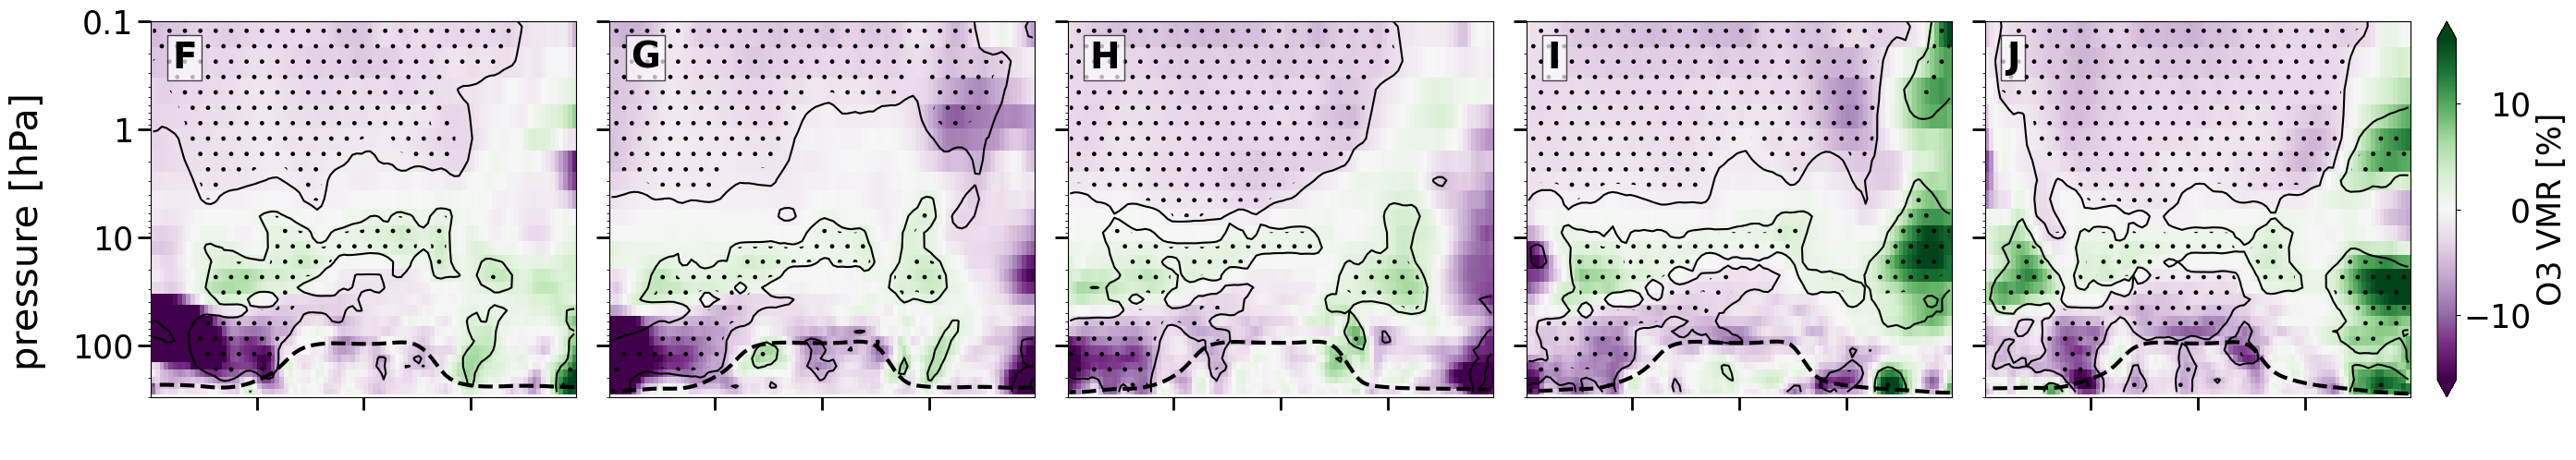

In [89]:
plot_var_row(diff, diff_pv, sel_var, cmap = 'PRGn', start_letter = 'f', xlabel_bool=False, to_pdf=True, set_title=False)

In [69]:
!pdfinfo O3_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf


Creator:        Matplotlib v3.9.2, https://matplotlib.org
Producer:       Matplotlib pdf backend v3.9.2
CreationDate:   Mon Nov 18 15:27:04 2024 CET
Tagged:         no
UserProperties: no
Suspects:       no
Form:           none
JavaScript:     no
Pages:          1
Encrypted:      no
Page size:      2006.23 x 399.14 pts
Page rot:       0
File size:      354108 bytes
Optimized:      no
PDF version:    1.4


In [90]:
!pdfinfo O3_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf


Creator:        Matplotlib v3.9.2, https://matplotlib.org
Producer:       Matplotlib pdf backend v3.9.2
CreationDate:   Mon Nov 18 15:52:31 2024 CET
Tagged:         no
UserProperties: no
Suspects:       no
Form:           none
JavaScript:     no
Pages:          1
Encrypted:      no
Page size:      2006.23 x 358.203 pts
Page rot:       0
File size:      352351 bytes
Optimized:      no
PDF version:    1.4


/tmp/ipykernel_7745/630369373.py:50: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  zip(p.axes.flat, p.name_dicts.flat, ascii_uppercase)


O3_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf


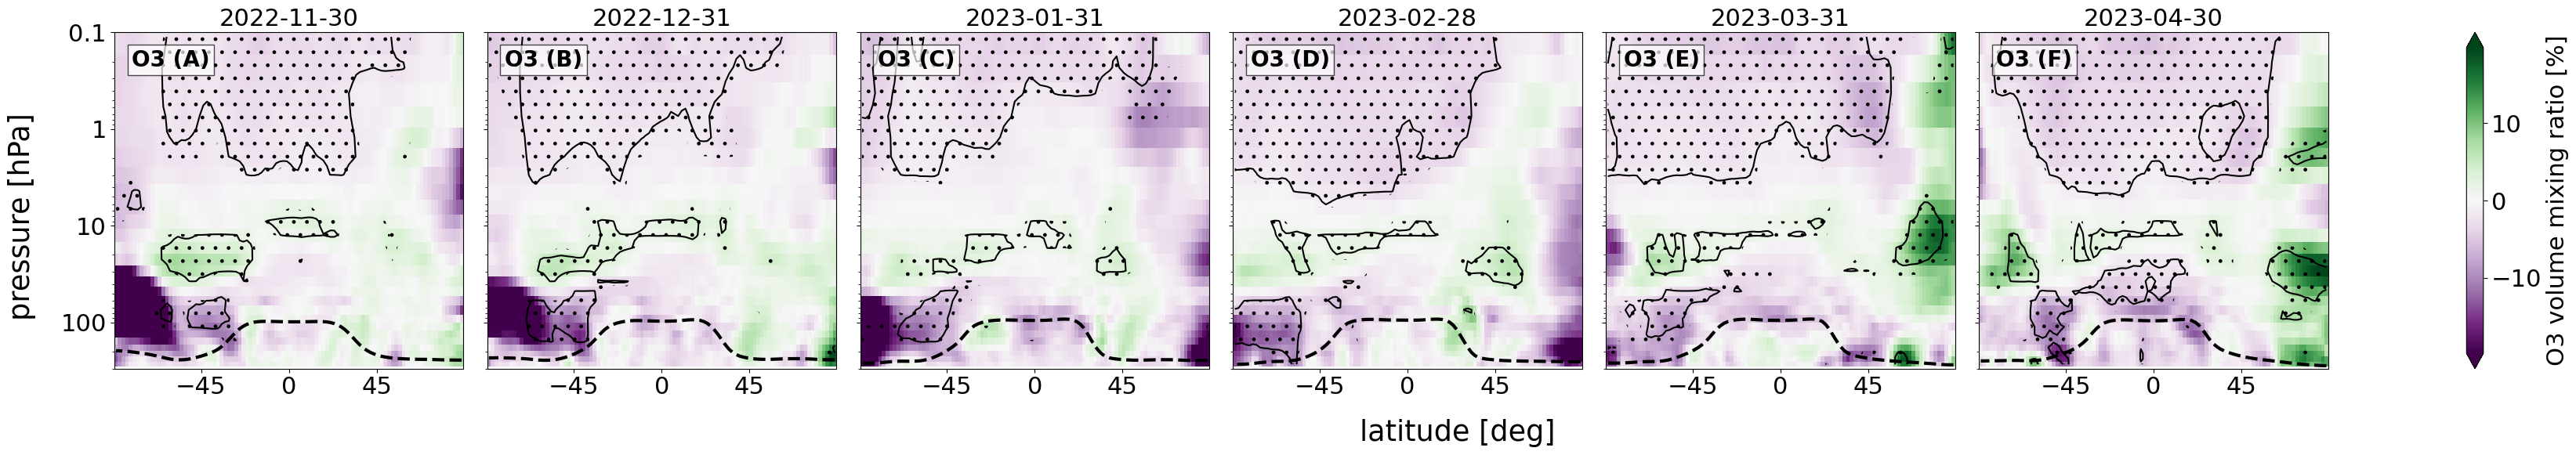

In [47]:
p = diff[:].plot(
    x="lat", col="time", yincrease=False, robust=True, cmap="PRGn", size = 6,
)


p.data = diff_pv  # u_pv #ttest_1samp(diff,'time')
kwargs = dict(
    # colors=("k"),
    add_colorbar=False,
    levels=[0, 0.05],
    colors="none",
    hatches=[".", None]
    # linewidths=np.linspace(1, 4, 4),
)
p.map_dataarray(xr.plot.contourf, "lat", "plev", **kwargs)


u_pv = xr_multipletest(diff_pv)[1]
p.data = u_pv  # ttest_1samp(diff,'time')
kwargs = dict(
    colors=("k"),
    add_colorbar=False,
    levels=[0, 0.32],  # 1-sigma
    # linewidths=np.linspace(1, 4, 4),
)
# p.map_dataarray(xr.plot.contour, "lat", "plev", **kwargs)


p.data = u_pv  # xr_multipletest(diff_pv)[1]#o3_pv
kwargs = dict(
    colors=("k"),
    add_colorbar=False,
    levels=[0, 0.05],
    # linewidths=np.linspace(1, 4, 4),
)
p.map_dataarray(xr.plot.contour, "lat", "plev", **kwargs)


p.set_titles("{value}")
p.set_xlabels(" ")
p.set_ylabels(" ")
p.fig.supxlabel("latitude [deg]")
p.fig.supylabel("pressure [hPa]", x = 0)

plt.ylim(300, 0.1)
plt.yscale("log")

lat = da_w_tpp.lat.values
for i, (ax, sel_dict, label) in enumerate(
    zip(p.axes.flat, p.name_dicts.flat, ascii_uppercase)
):
    fmt = mpl.ticker.FormatStrFormatter("%g")
    ax.yaxis.set_major_formatter(fmt)
    ax.text(
        0.05,
        0.95,
        ascii_uppercase[j],#f'{sel_var[:-2]} ({label})',
        transform=ax.transAxes,
        fontsize=20,
        fontweight="bold",
        va="top",
        bbox={"alpha": 0.7, "facecolor": "white"},
    )
    ax.set_xticks([-45, 0, 45])

    ax.plot(lat, da_w_tpp.sel(**sel_dict), "k--", lw=3)


outfile = f"{sel_var}_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf"
print(outfile)
plt.savefig(outfile, bbox_inches="tight")

## H2O

In [73]:
time_slice = slice("2022-12-01", "2023-04-30")
sel_dict = dict(time=time_slice, lat=slice(None, None))
sel_var = "H2O_m"


arr1 = ds_w_chem[sel_var].sel(**sel_dict).squeeze().load()
arr2 = ds_wo_chem[sel_var].sel(**sel_dict).squeeze().load()
diff = ((arr1 - arr2)).mean("ens")*1e6
#diff["time"] = map_time_str(diff.time)
diff.attrs["units"] = "ppmv"
diff.attrs["long_name"] = r"H$_2$O VMR"


t_stat, p_values = stats.ttest_ind(
    arr1, arr2, equal_var=False
)  # , nan_policy = nan_policy)
diff_pv = xr.DataArray(p_values, coords=diff.coords)

/tmp/ipykernel_33153/1259965813.py:64: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  zip(p.axes.flat, p.name_dicts.flat, letter_ls)


H2O_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf


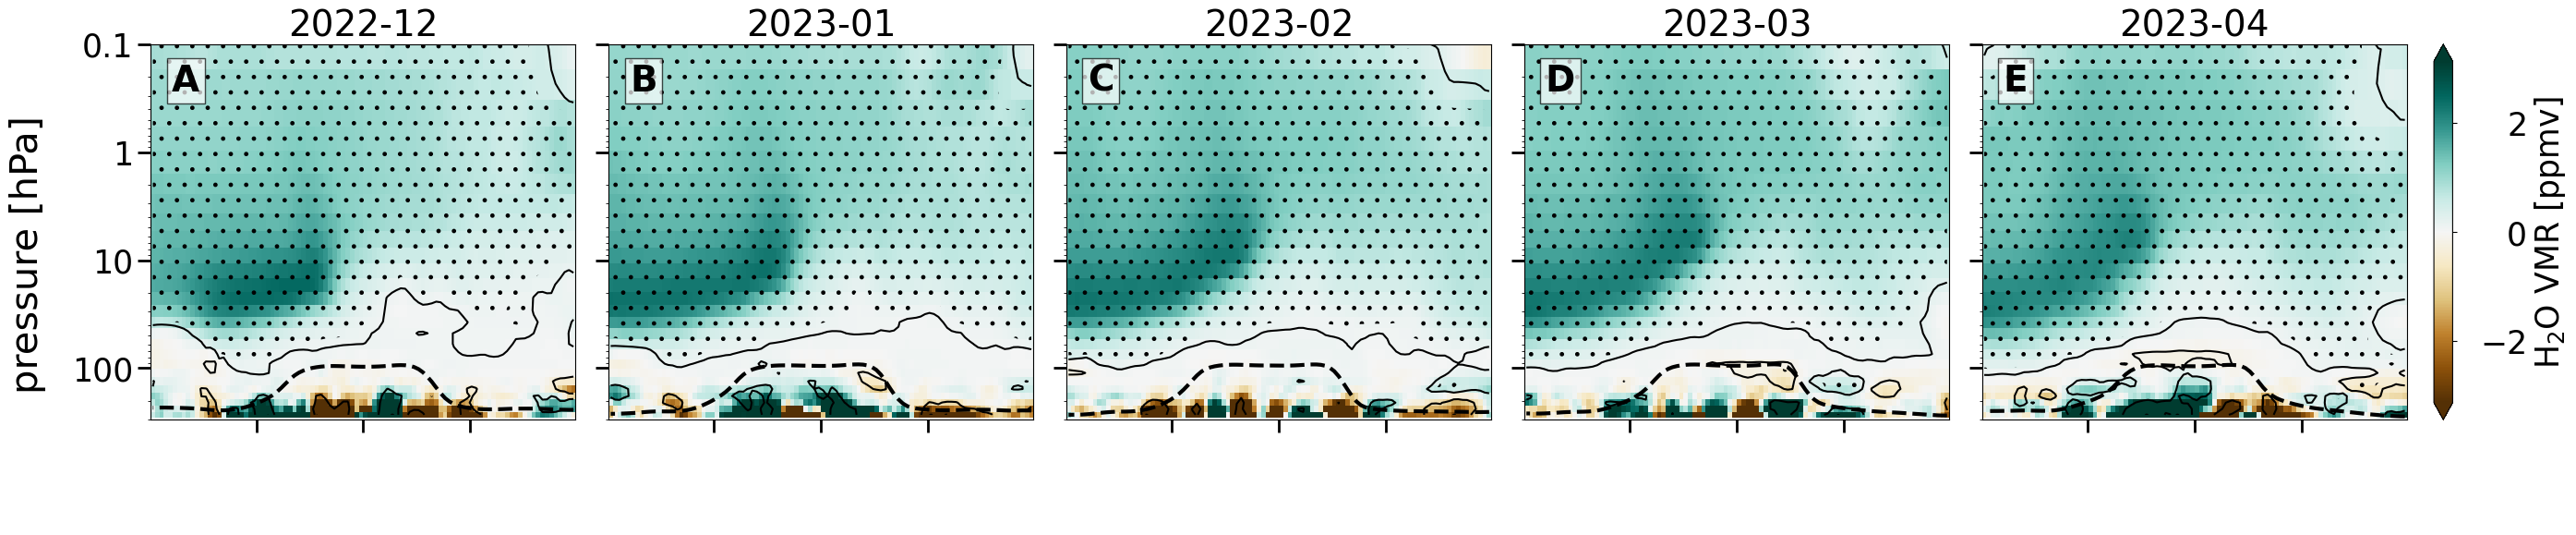

In [74]:
plot_var_row(diff, diff_pv, sel_var, cmap = 'BrBG', start_letter = 'a', xlabel_bool=False, to_pdf=True)

In [75]:
!pdfinfo H2O_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf


Creator:        Matplotlib v3.9.2, https://matplotlib.org
Producer:       Matplotlib pdf backend v3.9.2
CreationDate:   Mon Nov 18 15:35:38 2024 CET
Tagged:         no
UserProperties: no
Suspects:       no
Form:           none
JavaScript:     no
Pages:          1
Encrypted:      no
Page size:      2007.03 x 416.921 pts
Page rot:       0
File size:      296537 bytes
Optimized:      no
PDF version:    1.4


/tmp/ipykernel_7745/4077565843.py:50: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  zip(p.axes.flat, p.name_dicts.flat, ascii_uppercase)


H2O_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf


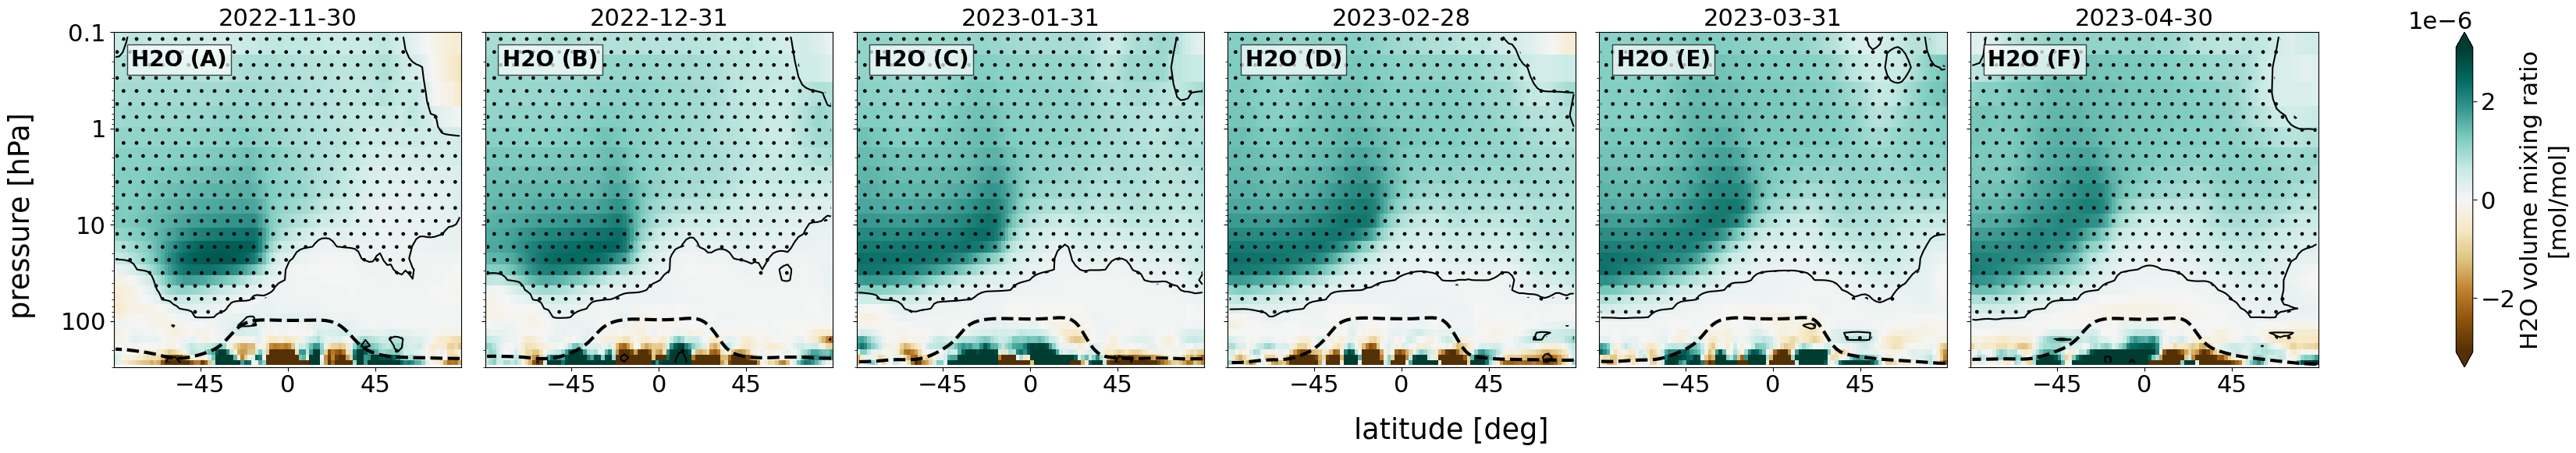

In [62]:
p = diff[:].plot(
    x="lat", col="time", yincrease=False, robust=True, cmap="BrBG", size = 6,
)


p.data = diff_pv  # u_pv #ttest_1samp(diff,'time')
kwargs = dict(
    # colors=("k"),
    add_colorbar=False,
    levels=[0, 0.05],
    colors="none",
    hatches=[".", None]
    # linewidths=np.linspace(1, 4, 4),
)
p.map_dataarray(xr.plot.contourf, "lat", "plev", **kwargs)


u_pv = xr_multipletest(diff_pv)[1]
p.data = u_pv  # ttest_1samp(diff,'time')
kwargs = dict(
    colors=("k"),
    add_colorbar=False,
    levels=[0, 0.32],  # 1-sigma
    # linewidths=np.linspace(1, 4, 4),
)
# p.map_dataarray(xr.plot.contour, "lat", "plev", **kwargs)


p.data = u_pv  # xr_multipletest(diff_pv)[1]#o3_pv
kwargs = dict(
    colors=("k"),
    add_colorbar=False,
    levels=[0, 0.05],
    # linewidths=np.linspace(1, 4, 4),
)
p.map_dataarray(xr.plot.contour, "lat", "plev", **kwargs)


p.set_titles("{value}")
p.set_xlabels(" ")
p.set_ylabels(" ")
p.fig.supxlabel("latitude [deg]")
p.fig.supylabel("pressure [hPa]", x = 0)

plt.ylim(300, 0.1)
plt.yscale("log")

lat = da_w_tpp.lat.values
for i, (ax, sel_dict, label) in enumerate(
    zip(p.axes.flat, p.name_dicts.flat, ascii_uppercase)
):
    fmt = mpl.ticker.FormatStrFormatter("%g")
    ax.yaxis.set_major_formatter(fmt)
    ax.text(
        0.05,
        0.95,
        f'{sel_var[:-2]} ({label})',
        transform=ax.transAxes,
        fontsize=20,
        fontweight="bold",
        va="top",
        bbox={"alpha": 0.7, "facecolor": "white"},
    )
    ax.set_xticks([-45, 0, 45])

    ax.plot(lat, da_w_tpp.sel(**sel_dict), "k--", lw=3)


outfile = f"{sel_var}_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf"
print(outfile)
plt.savefig(outfile, bbox_inches="tight")

### profiles year by year

In [10]:
weights = np.cos(np.deg2rad(ds_wo_chem.lat))
weights.name = "weights"
weights


<xarray.DataArray 'weights' (lat: 96)> Size: 768B
array([0.02491778, 0.05717144, 0.08955539, 0.12188768, 0.15410725,
       0.1861715 , 0.21804295, 0.24968611, 0.28106651, 0.31215034,
       0.34290431, 0.37329559, 0.40329182, 0.43286109, 0.46197199,
       0.49059359, 0.51869553, 0.54624798, 0.57322171, 0.59958812,
       0.62531924, 0.65038779, 0.6747672 , 0.6984316 , 0.72135592,
       0.74351585, 0.76488791, 0.78544943, 0.80517862, 0.82405458,
       0.84205728, 0.85916766, 0.87536757, 0.89063985, 0.9049683 ,
       0.91833775, 0.93073401, 0.94214396, 0.9525555 , 0.96195759,
       0.97034027, 0.97769466, 0.98401296, 0.98928847, 0.9935156 ,
       0.99668988, 0.99880794, 0.99986753, 0.99986753, 0.99880794,
       0.99668988, 0.9935156 , 0.98928847, 0.98401296, 0.97769466,
       0.97034027, 0.96195759, 0.9525555 , 0.94214396, 0.93073401,
       0.91833775, 0.9049683 , 0.89063985, 0.87536757, 0.85916766,
       0.84205728, 0.82405458, 0.80517862, 0.78544943, 0.76488791,
       0.74351585, 0.72135592, 0.6984316 , 0.6747672 , 0.65038779,
       0.62531924, 0.59958812, 0.57322171, 0.54624798, 0.51869553,
       0.49059359, 0.46197199, 0.43286109, 0.40329182, 0.37329559,
       0.34290431, 0.31215034, 0.28106651, 0.24968611, 0.21804295,
       0.1861715 , 0.15410725, 0.12188768, 0.08955539, 0.05717144,
       0.02491778])
Coordinates:
  * lat      (lat) float64 768B 88.57 86.72 84.86 83.0 ... -84.86 -86.72 -88.57
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    axis:           Y

In [28]:
time_slice = slice("2022-01-01",None)

sel_dict = dict(time=time_slice, lat=slice(82, -82), plev = slice(None,100))
sel_var = "H2O_m"


arr1 = ds_w_chem[sel_var].sel(**sel_dict).weighted(weights).mean(['lat','ens']).squeeze()#.load()
arr2 = ds_wo_chem[sel_var].sel(**sel_dict).weighted(weights).mean(['lat','ens']).squeeze()#.load()

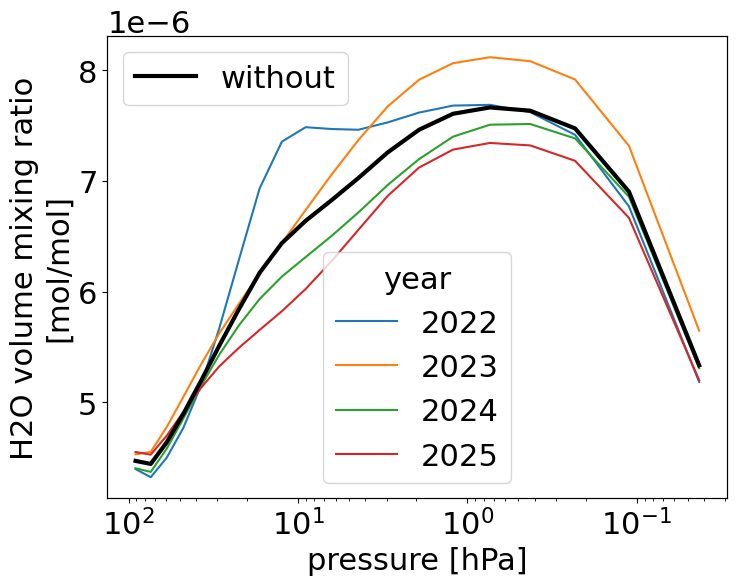

In [39]:
p = arr1.groupby('time.year').mean().plot.line(x = 'plev', xincrease = False, size = 6)
ax = p[0].axes
ax.set_xscale('log')
ax.set_title('')

ax2 = ax.twinx()
arr1.mean('time').plot.line(x = 'plev', xincrease = False, label = 'without', color = 'k', lw = 3, ax = ax2)
ax2.set_title('')
ax2.legend(loc = 'upper left')
ax2.set_ylabel('')
#ax2.set_yticks
ax2.set_ylim(*ax.get_ylim())
ax2.get_yaxis().set_visible(False)
#ax.set_xlim(100,None)
#plt.legend()

## OH

In [76]:
time_slice = slice("2022-12-01", "2023-04-30")
sel_dict = dict(time=time_slice, lat=slice(None, None))
sel_var = "OH_m"


arr1 = ds_w_hox[sel_var].sel(**sel_dict).squeeze().load()
arr2 = ds_wo_hox[sel_var].sel(**sel_dict).squeeze().load()
diff = ((arr1 - arr2) / arr1 * 100).mean("ens")
#diff["time"] = map_time_str(diff.time)
diff.attrs["units"] = "%"
diff.attrs["long_name"] = "OH VMR"


t_stat, p_values = stats.ttest_ind(
    arr1, arr2, equal_var=False
)  # , nan_policy = nan_policy)
diff_pv = xr.DataArray(p_values, coords=diff.coords)

/tmp/ipykernel_33153/1259965813.py:64: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  zip(p.axes.flat, p.name_dicts.flat, letter_ls)


OH_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf


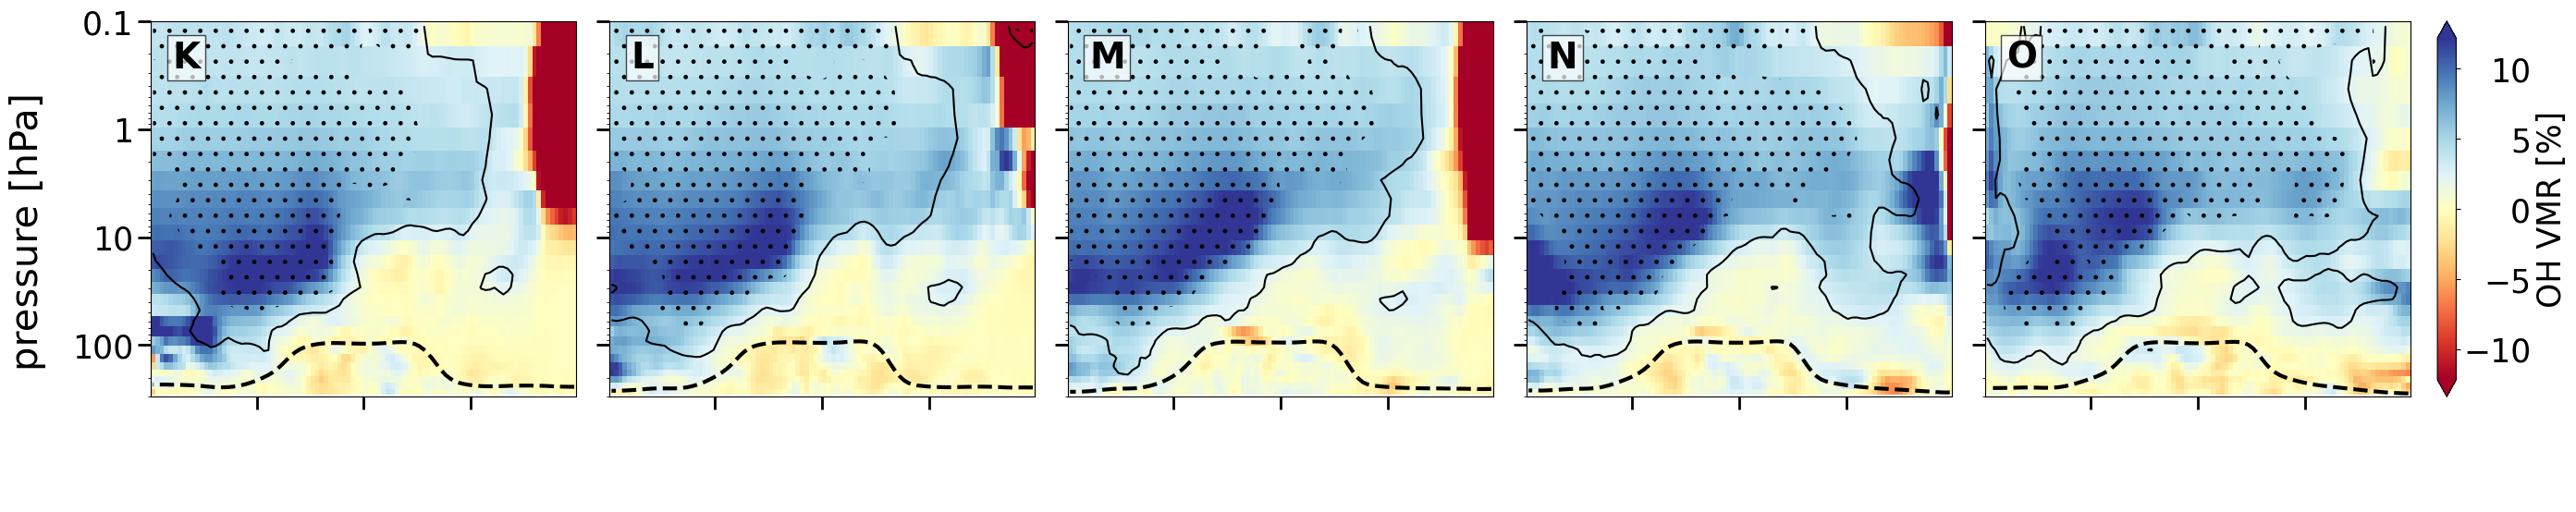

In [77]:
plot_var_row(diff, diff_pv, sel_var, cmap = 'RdYlBu', start_letter = 'k', xlabel_bool=False, to_pdf=True, set_title=False)

In [78]:
!pdfinfo OH_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf


Creator:        Matplotlib v3.9.2, https://matplotlib.org
Producer:       Matplotlib pdf backend v3.9.2
CreationDate:   Mon Nov 18 15:36:27 2024 CET
Tagged:         no
UserProperties: no
Suspects:       no
Form:           none
JavaScript:     no
Pages:          1
Encrypted:      no
Page size:      2006.23 x 399.14 pts
Page rot:       0
File size:      304517 bytes
Optimized:      no
PDF version:    1.4


/tmp/ipykernel_41396/1973319808.py:50: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  zip(p.axes.flat, p.name_dicts.flat, ascii_uppercase)


OH_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf


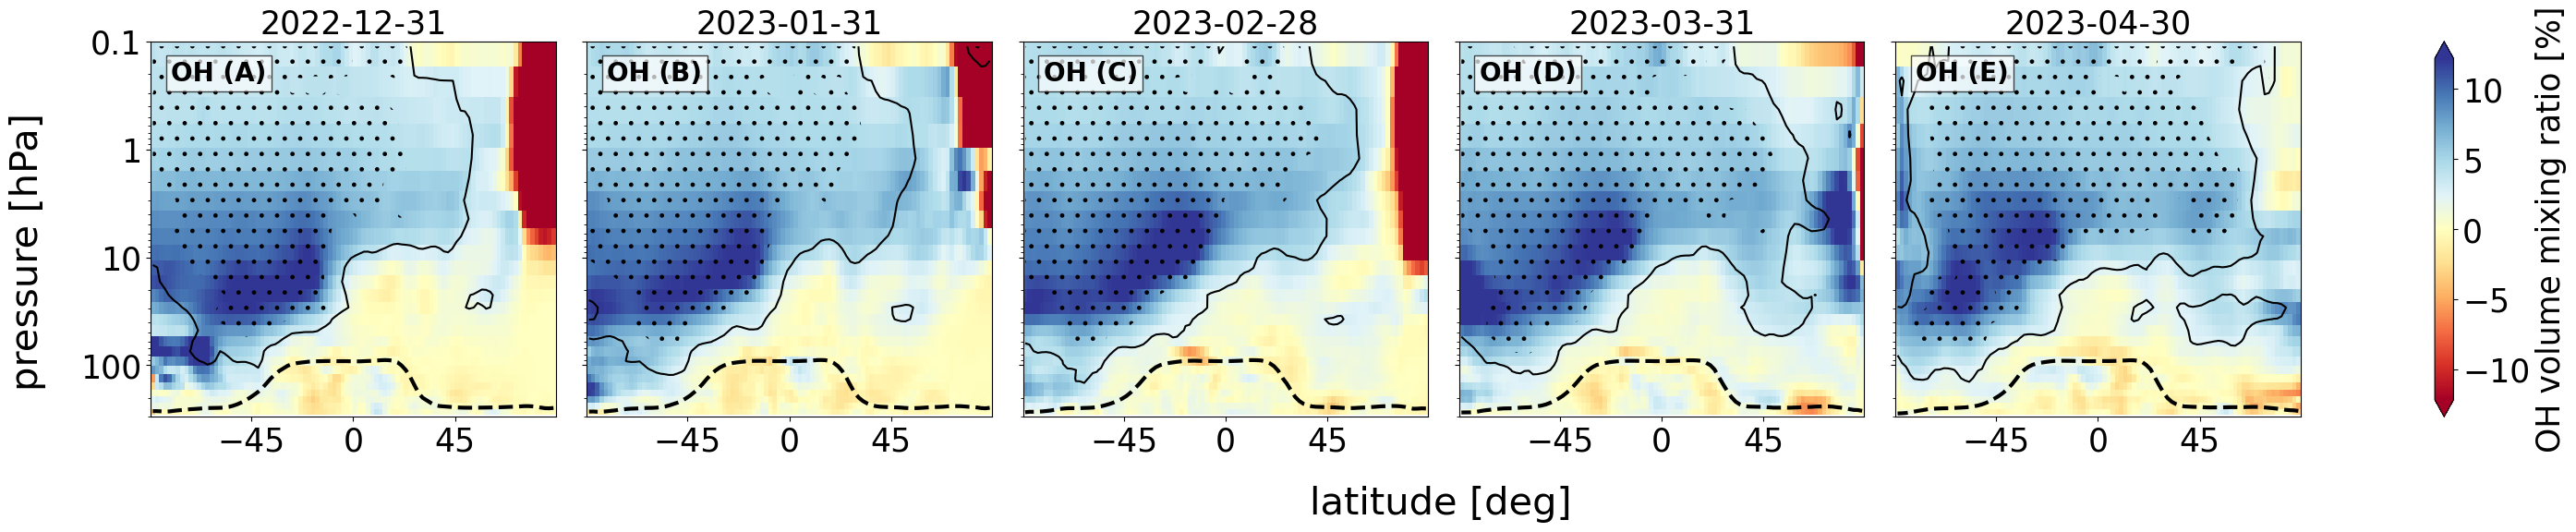

In [230]:
p = diff[:].plot(
    x="lat", col="time", yincrease=False, robust=True, cmap="RdYlBu", size = 6,
)


p.data = diff_pv  # u_pv #ttest_1samp(diff,'time')
kwargs = dict(
    # colors=("k"),
    add_colorbar=False,
    levels=[0, 0.05],
    colors="none",
    hatches=[".", None]
    # linewidths=np.linspace(1, 4, 4),
)
p.map_dataarray(xr.plot.contourf, "lat", "plev", **kwargs)


u_pv = xr_multipletest(diff_pv, method='fdr_bh')[1]
p.data = u_pv  # ttest_1samp(diff,'time')
kwargs = dict(
    colors=("k"),
    add_colorbar=False,
    levels=[0, 0.32],  # 1-sigma
    # linewidths=np.linspace(1, 4, 4),
)
# p.map_dataarray(xr.plot.contour, "lat", "plev", **kwargs)


p.data = u_pv  # xr_multipletest(diff_pv)[1]#o3_pv
kwargs = dict(
    colors=("k"),
    add_colorbar=False,
    levels=[0, 0.3],
    # linewidths=np.linspace(1, 4, 4),
)
p.map_dataarray(xr.plot.contour, "lat", "plev", **kwargs)


p.set_titles("{value}")
p.set_xlabels(" ")
p.set_ylabels(" ")
p.fig.supxlabel("latitude [deg]")
p.fig.supylabel("pressure [hPa]", x = 0)

plt.ylim(300, 0.1)
plt.yscale("log")

lat = da_w_tpp.lat.values
for i, (ax, sel_dict, label) in enumerate(
    zip(p.axes.flat, p.name_dicts.flat, ascii_uppercase)
):
    fmt = mpl.ticker.FormatStrFormatter("%g")
    ax.yaxis.set_major_formatter(fmt)
    ax.text(
        0.05,
        0.95,
        f'{sel_var[:-2]} ({label})',
        transform=ax.transAxes,
        fontsize=20,
        fontweight="bold",
        va="top",
        bbox={"alpha": 0.7, "facecolor": "white"},
    )
    ax.set_xticks([-45, 0, 45])

    ax.plot(lat, da_w_tpp.sel(**sel_dict), "k--", lw=3)


outfile = f"{sel_var}_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf"
print(outfile)
#plt.savefig(outfile, bbox_inches="tight")

In [41]:
!pdfinfo OH_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf

Creator:        Matplotlib v3.8.0, https://matplotlib.org
Producer:       Matplotlib pdf backend v3.8.0
CreationDate:   Fri Jun 14 15:35:03 2024 CEST
Tagged:         no
UserProperties: no
Suspects:       no
Form:           none
JavaScript:     no
Pages:          1
Encrypted:      no
Page size:      2007.79 x 399.14 pts
Page rot:       0
File size:      304484 bytes
Optimized:      no
PDF version:    1.4


In [79]:
!pdfinfo te_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf

Creator:        Matplotlib v3.9.2, https://matplotlib.org
Producer:       Matplotlib pdf backend v3.9.2
CreationDate:   Mon Nov 18 15:27:29 2024 CET
Tagged:         no
UserProperties: no
Suspects:       no
Form:           none
JavaScript:     no
Pages:          1
Encrypted:      no
Page size:      2006.23 x 399.14 pts
Page rot:       0
File size:      315403 bytes
Optimized:      no
PDF version:    1.4


In [80]:
399.14*4

1596.56

In [277]:
358.203*4

1432.812

In [84]:
!pdfcrop OH_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf
!pdfcrop O3_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf
!pdfcrop te_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf
!pdfcrop H2O_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf

PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `OH_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally-crop.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `O3_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally-crop.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `te_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally-crop.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `H2O_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally-crop.pdf'.


In [91]:
!pdfinfo O3_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf

Creator:        Matplotlib v3.9.2, https://matplotlib.org
Producer:       Matplotlib pdf backend v3.9.2
CreationDate:   Mon Nov 18 15:52:31 2024 CET
Tagged:         no
UserProperties: no
Suspects:       no
Form:           none
JavaScript:     no
Pages:          1
Encrypted:      no
Page size:      2006.23 x 358.203 pts
Page rot:       0
File size:      352351 bytes
Optimized:      no
PDF version:    1.4


In [96]:
!pdfinfo te_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf

Creator:        Matplotlib v3.9.2, https://matplotlib.org
Producer:       Matplotlib pdf backend v3.9.2
CreationDate:   Mon Nov 18 15:27:29 2024 CET
Tagged:         no
UserProperties: no
Suspects:       no
Form:           none
JavaScript:     no
Pages:          1
Encrypted:      no
Page size:      2006.23 x 399.14 pts
Page rot:       0
File size:      315403 bytes
Optimized:      no
PDF version:    1.4


In [97]:
!pdfjam O3_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf O3_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf O3_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf te_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf --nup 1x4  --papersize  '{2006.23px, 1432.812px}' --outfile figureout-test.pdf

          ----
  pdfjam: This is pdfjam version 2.08.
  pdfjam: Reading any site-wide or user-specific defaults...
          (none found)
  pdfjam: Effective call for this run of pdfjam:
          /usr/bin/pdfjam --nup '1x4' --papersize '{2006.23px, 1432.812px}' --outfile figureout-test.pdf -- O3_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf - O3_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf - O3_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf - te_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf - 
  pdfjam: Calling pdflatex...
  pdfjam: Finished.  Output was to 'figureout-test.pdf'.


In [85]:
!pdfjam  *_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally-crop.pdf  --nup 1x4 --papersize '{2006.23px, 1596.56px}' --outfile figureout-crop.pdf

          ----
  pdfjam: This is pdfjam version 2.08.
  pdfjam: Reading any site-wide or user-specific defaults...
          (none found)
  pdfjam: Effective call for this run of pdfjam:
          /usr/bin/pdfjam --nup '1x4' --papersize '{2006.23px, 1596.56px}' --outfile figureout-crop.pdf -- H2O_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally-crop.pdf - O3_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally-crop.pdf - OH_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally-crop.pdf - te_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally-crop.pdf - 
  pdfjam: Calling pdflatex...
  pdfjam: Finished.  Output was to 'figureout-crop.pdf'.


In [83]:
!pwd

/home/kales/notebooks


In [288]:
!pdfjam  *_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf  --nup 1x4 --papersize '{2007.79px, 1432.812px}' --outfile figureout.pdf

          ----
  pdfjam: This is pdfjam version 2.08.
  pdfjam: Reading any site-wide or user-specific defaults...
          (none found)
  pdfjam: Effective call for this run of pdfjam:
          /usr/bin/pdfjam --nup '1x4' --papersize '{2007.79px, 1432.812px}' --outfile figureout.pdf -- H2O_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf - O3_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf - OH_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf - te_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf - 
  pdfjam: Calling pdflatex...
  pdfjam: Finished.  Output was to 'figureout.pdf'.


In [43]:
#!pdfcrop OH_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf
#!pdfcrop O3_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf
#!pdfcrop te_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf
#!pdfcrop H2O_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf
!pdfjam  *_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf --nup 1x4 --outfile figureout.pdf
!pdfcrop figureout.pdf all_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally_FIG1.pdf

          ----
  pdfjam: This is pdfjam version 2.08.
  pdfjam: Reading any site-wide or user-specific defaults...
          (none found)
  pdfjam: Effective call for this run of pdfjam:
          /usr/bin/pdfjam --nup '1x4' --outfile figureout.pdf -- H2O_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf - O3_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf - OH_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf - te_m_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally.pdf - 
  pdfjam: Calling pdflatex...
  pdfjam: Finished.  Output was to 'figureout.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `all_time-evolution_2022-2023_-diff_mm_zon-htt-new-globally_FIG1.pdf'.


## 2t

In [329]:
time_slice = "2023-04"#slice("2022-11-01", "2023-04-30")
sel_dict = dict(time=time_slice, lat=slice(None, None))
sel_var = "2t"


arr1 = ds_w_2t[sel_var].sel(**sel_dict).squeeze()
arr2 = ds_wo_2t[sel_var].sel(**sel_dict).squeeze()
diff = arr1.mean("ens") - arr2.mean("ens")
#diff["time"] = map_time_str(diff.time)
#diff.attrs["units"] = "%"

t_stat, p_values = stats.ttest_ind(
    arr1, arr2, equal_var=False
)  # , nan_policy = nan_policy)
diff_pv = xr.DataArray(p_values, coords=diff.coords)
diff_pv_fdr = xr_multipletest(diff_pv)[1]

2t_map_2023-04_FIG4.pdf


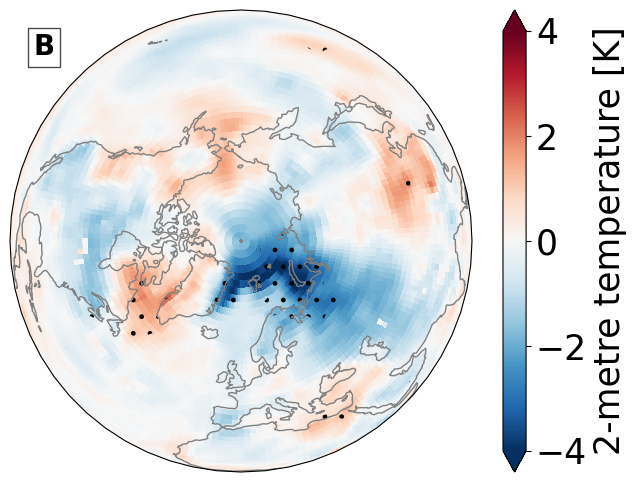

In [331]:
p = diff.plot(
    subplot_kws=dict(projection=ccrs.Orthographic(0, 90), facecolor="gray"),
    size = 6,
    transform=ccrs.PlateCarree(),
    #robust = True,
    vmax = 4,
    #cmap=cm.to_matplotlib(),#"PuOr_r",
    #levels = 21,
    extend = 'both'
    
)

ax = p.axes

ax.text(
            0.05,
            0.95,
            ascii_uppercase[1],#f'{sel_var[:-2]} ({label})',
            transform=ax.transAxes,
            fontsize=20,
            fontweight="bold",
            va="top",
            bbox={"alpha": 0.7, "facecolor": "white"},
        )

kwargs = dict(
    # colors=("k"),
    add_colorbar=False,
    levels=[0, 0.05],
    colors="none",
    hatches=[
        ".",#"//",
        None,
    ],
    transform=ccrs.PlateCarree()
    # linewidths=np.linspace(1, 4, 4),
)

p.data = diff_pv
diff_pv.plot.contourf(ax=ax, **kwargs)
kwargs['levels'] = [0,0.01]
kwargs['hatches'] = ["\\",  None]
#diff_pv.plot.contourf(ax=ax, **kwargs)

kwargs = dict(
    yincrease= False,
    colors=("k"),
    add_colorbar=False,
    levels=[0, 0.3],
    transform=ccrs.PlateCarree()
)
diff_pv_fdr.plot.contour( ax=ax, **kwargs)
#p.set_titles("{value}")

#ax.set_title(np.datetime_as_string(diff.time.values, unit='M'))
ax.set_title('')

p.axes.set_global()
p.axes.coastlines(color = 'gray')

outfile = f"{sel_var}_map_{time_slice}_FIG4.pdf"
print(outfile)
plt.savefig(outfile, bbox_inches="tight")

## SLP

In [332]:
time_slice = "2023-04"#slice("2022-11-01", "2023-04-30")
sel_dict = dict(time=time_slice, lat=slice(None, None))
sel_var = "psl"


arr1 = ds_w_slp[sel_var].sel(**sel_dict).squeeze()
arr2 = ds_wo_slp[sel_var].sel(**sel_dict).squeeze()
diff = arr1.mean("ens") - arr2.mean("ens")
#diff["time"] = map_time_str(diff.time)
#diff.attrs["units"] = "%"
diff.attrs['standard_name'] = 'SLP'

t_stat, p_values = stats.ttest_ind(
    arr1, arr2, equal_var=False
)  # , nan_policy = nan_policy)
diff_pv = xr.DataArray(p_values, coords=diff.coords)
diff_pv_fdr = xr_multipletest(diff_pv)[1]

psl_map_2023-04_FIG4.pdf


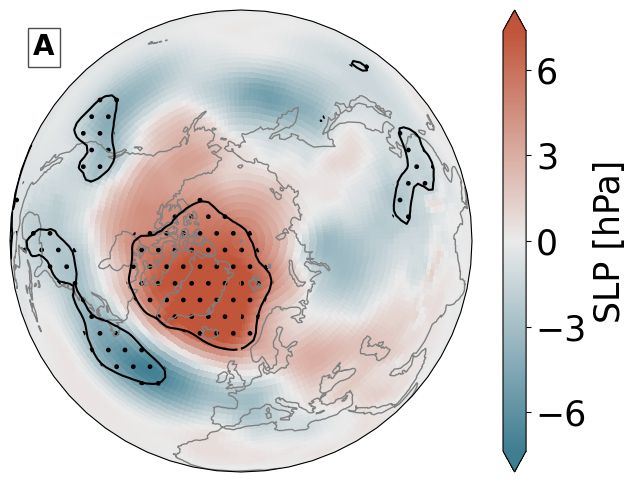

In [333]:
cm = Colormap('vispy:RdBu_r')#'crameri:vik')

p = diff.plot(
    subplot_kws=dict(projection=ccrs.Orthographic(0, 90), facecolor="gray"),
    size = 6,
    transform=ccrs.PlateCarree(),
    robust = True,
    cmap=cm.to_matplotlib(),#"PuOr_r",
    #levels = 21,
    extend = 'both',
    cbar_kwargs = dict(ticks=[-6,-3, 0, 3,6])
    
)

ax = p.axes


kwargs = dict(
    # colors=("k"),
    add_colorbar=False,
    levels=[0, 0.05],
    colors="none",
    hatches=[
        ".",#"//",
        None,
    ],
    transform=ccrs.PlateCarree()
    # linewidths=np.linspace(1, 4, 4),
)

p.data = diff_pv
diff_pv.plot.contourf(ax=ax, **kwargs)
kwargs['levels'] = [0,0.01]
kwargs['hatches'] = ["\\",  None]
#diff_pv.plot.contourf(ax=ax, **kwargs)

kwargs = dict(
    yincrease= False,
    colors=("k"),
    add_colorbar=False,
    levels=[0, 0.32],
    transform=ccrs.PlateCarree()
)
diff_pv_fdr.plot.contour( ax=ax, **kwargs)

kwargs = dict(
    yincrease= False,
    colors=("k"),
    add_colorbar=False,
    levels=[0, 0.05],
    transform=ccrs.PlateCarree()
)

ax.text(
            0.05,
            0.95,
            ascii_uppercase[0],#f'{sel_var[:-2]} ({label})',
            transform=ax.transAxes,
            fontsize=20,
            fontweight="bold",
            va="top",
            bbox={"alpha": 0.7, "facecolor": "white"},
        )
        
#ax.set_title(np.datetime_as_string(sel_dict['time'], unit='M'))
#diff_pv_fdr.plot.contour( ax=ax, **kwargs)
#ax.set_title(np.datetime_as_string(diff.time.values, unit='M'))
ax.set_title('')
p.axes.set_global()
p.axes.coastlines(color = 'gray')

outfile = f"{sel_var}_map_{time_slice}_FIG4.pdf"
print(outfile)
plt.savefig(outfile, bbox_inches="tight")